In [107]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial
from scipy.spatial.distance import pdist, cdist, squareform

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    transcriptor, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, _prepare_nice_labels, plot_mutspec96
from pymutspec.draw.sbs_orders import ordered_sbs192_kp

from utils import calc_mutspec_class, sbs2effect, effect2sbs

sns.set_style()
%matplotlib inline

In [92]:
possible_sbs6 = ["C>A", "C>G", "C>T", "T>A", "T>C", "T>G"]
possible_sbs96 = [x for x in possible_sbs192 if x[2:5] in possible_sbs6]
print(possible_sbs96)

['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G'

## Load and prepare data

In [49]:
species_spectra = pd.read_csv('../data/MutSpecVertebratescytb.csv')
cosmic = pd.read_table('../data/external/COSMIC_v3.3.1_SBS_GRCh37.txt', index_col=0)

In [50]:
species_spectra.head(2)

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii


Drop SBS without transitions

In [94]:
transitions_sbs = ['C>T', 'A>G', 'G>A', 'T>C'] 
transversions_sbs = [x for x in possible_sbs12 if x not in transitions_sbs]

cutoff_ts_share = 0.25
x = cosmic.loc[cosmic.index.str.slice(2,5).isin(transitions_sbs)].sum() 
used_sbs =  x[x > cutoff_ts_share].index.values
cosmic_filtered = cosmic[used_sbs]

#Reformat cosmic table
cosmic_filtered = cosmic_filtered.T[possible_sbs96]

cosmic_filtered.head().round(4)

Type,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
SBS1,0.0009,0.0023,0.0002,0.0013,0.0003,0.0018,0.0001,0.0000,0.0016,0.0003,...,0.0001,0.0002,0.0000,0.0000,0.0003,0.0000,0.0000,0.0001,0.0006,0.0000
SBS2,0.0000,0.0001,0.0001,0.0001,0.0002,0.0001,0.0000,0.0004,0.0001,0.0000,...,0.0001,0.0002,0.0002,0.0001,0.0000,0.0000,0.0000,0.0001,0.0001,0.0000
SBS3,0.0208,0.0165,0.0018,0.0122,0.0225,0.0253,0.0025,0.0154,0.0071,0.0109,...,0.0107,0.0070,0.0044,0.0023,0.0109,0.0058,0.0073,0.0063,0.0081,0.0105
SBS5,0.0120,0.0094,0.0018,0.0066,0.0074,0.0061,0.0035,0.0065,0.0102,0.0076,...,0.0061,0.0073,0.0025,0.0017,0.0053,0.0023,0.0052,0.0066,0.0069,0.0135
SBS6,0.0004,0.0005,0.0001,0.0002,0.0018,0.0041,0.0017,0.0096,0.0004,0.0009,...,0.0009,0.0013,0.0000,0.0002,0.0003,0.0008,0.0001,0.0003,0.0003,0.0010


Filter out species without nice spectrum:
at least 16 mtypes and 40 observed mutations

In [159]:
gr1 = species_spectra[~(species_spectra.MutSpec <= 0)].groupby("Species").Mut.count()
gr2 = species_spectra.groupby("Species").Observed.sum()
assert (gr1.index == gr2.index).all()
used_species = gr1[(gr1 > 16) & (gr2 > 40)].index.values
print(len(used_species))

species_spectra = species_spectra[species_spectra.Species.isin(used_species)]

643


In [160]:
cls_spectra = calc_mutspec_class(species_spectra)
for d in [cls_spectra, species_spectra]:
    d["sbs192h"] = d.Mut
    d["sbs12h"]  = d["sbs192h"].str.slice(2, 5)
    # d["sbs192l"] = d["sbs192h"].apply(rev_comp)
    # d["sbs12l"]  = d["sbs12h"].str.translate(transcriptor)
cls_spectra

,Class,Mut,MutSpec,sbs192h,sbs12h
0,Actinopterygii,A[A>C]A,0.000914,A[A>C]A,A>C
1,Actinopterygii,A[A>C]C,0.001387,A[A>C]C,A>C
2,Actinopterygii,A[A>C]G,0.000192,A[A>C]G,A>C
3,Actinopterygii,A[A>C]T,0.000000,A[A>C]T,A>C
4,Actinopterygii,A[A>G]A,0.010816,A[A>G]A,A>G
...,...,...,...,...,...
955,Mammalia,T[T>C]T,0.001801,T[T>C]T,T>C
956,Mammalia,T[T>G]A,0.000316,T[T>G]A,T>G
957,Mammalia,T[T>G]C,0.000406,T[T>G]C,T>G
958,Mammalia,T[T>G]G,0.000590,T[T>G]G,T>G


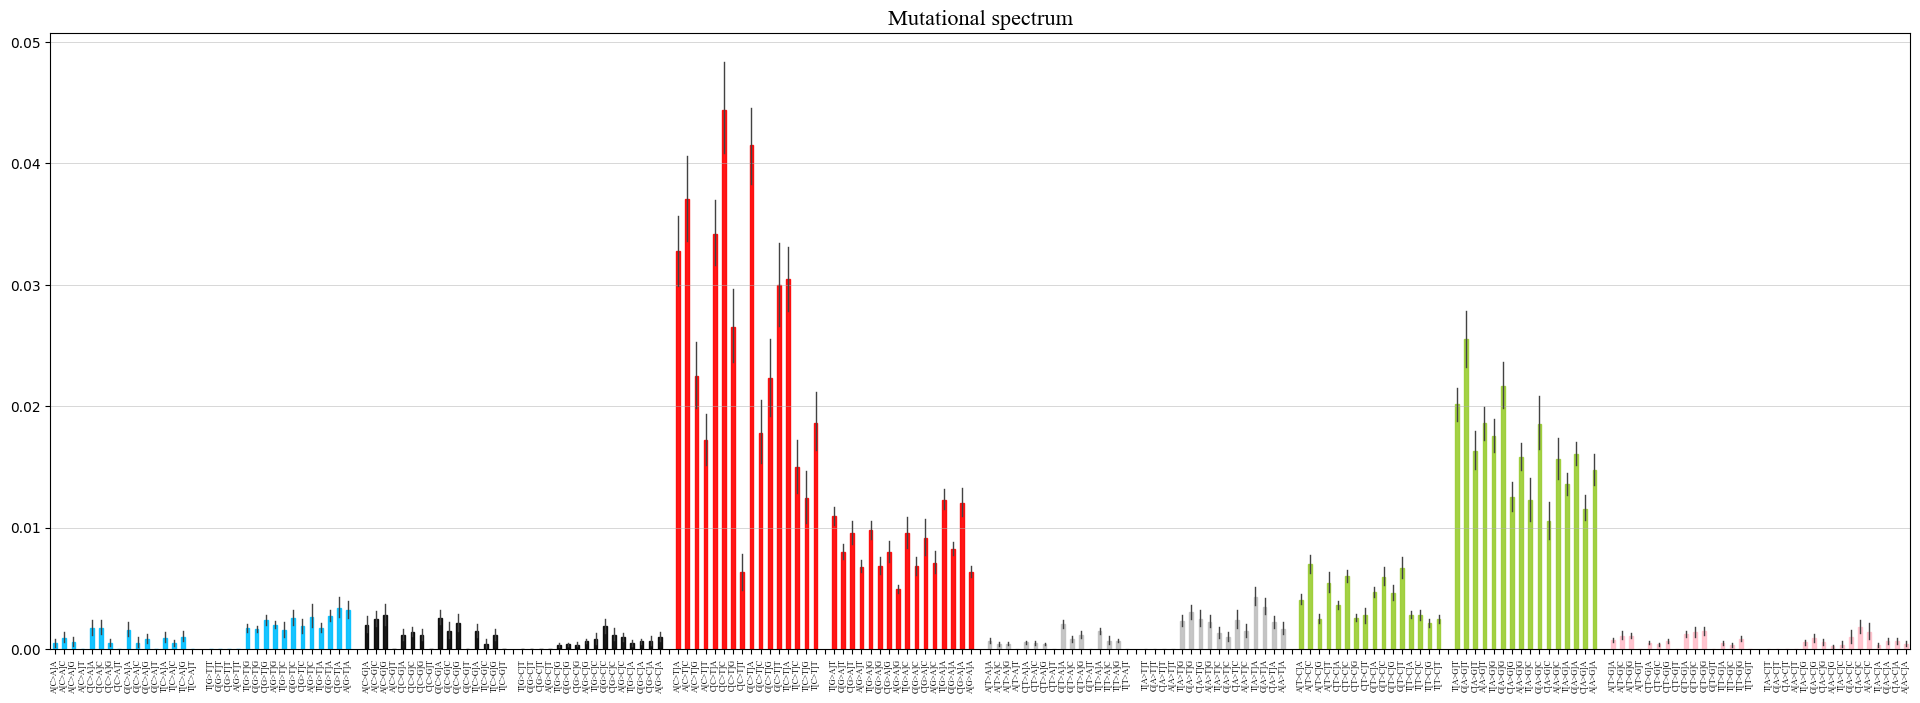

In [161]:
plot_mutspec192(species_spectra)

## New compare
species-wise

In [162]:
def complete_sbs_columns(df: pd.DataFrame, ncomp=96):
    if ncomp == 96:
        possible_sbs = possible_sbs96
    elif ncomp == 192:
        possible_sbs = possible_sbs192
    else:
        raise NotImplementedError
    
    df = df.copy()
    if len(df.columns) != 192:
        for sbs in set(possible_sbs).difference(df.columns.values):
            df[sbs] = 0.
    df = df[possible_sbs]
    return df

### Prepare species dataset

1. only transitions on light 

In [163]:
a = species_spectra[species_spectra.sbs12h == "G>A"]
b = species_spectra[species_spectra.sbs12h == "T>C"]
a['sbs96'] = a.sbs192h.apply(rev_comp)
b['sbs96'] = b.sbs192h

species_transitions_raw = pd.concat([a,b], ignore_index=True)
species_transitions = complete_sbs_columns(species_transitions_raw\
        .groupby(["Class", "Species", "sbs96"]).MutSpec.sum().unstack())
species_transitions.sample(5).round(4)

sbs96                                        A[C>A]A  A[C>A]C  A[C>A]G  \
Class          Species                                                   
Actinopterygii Acrossocheilus_beijiangensis      0.0      0.0      0.0   
Mammalia       Gazella_subgutturosa              0.0      0.0      0.0   
               Crocidura_attenuata               0.0      0.0      0.0   
Actinopterygii Gymnocypris_waddellii             0.0      0.0      0.0   
Mammalia       Papio_ursinus                     0.0      0.0      0.0   

sbs96                                        A[C>A]T  C[C>A]A  C[C>A]C  \
Class          Species                                                   
Actinopterygii Acrossocheilus_beijiangensis      0.0      0.0      0.0   
Mammalia       Gazella_subgutturosa              0.0      0.0      0.0   
               Crocidura_attenuata               0.0      0.0      0.0   
Actinopterygii Gymnocypris_waddellii             0.0      0.0      0.0   
Mammalia       Papio_ursinus                     0.0      0.0      0.0   

sbs96                                        C[C>A]G  C[C>A]T  G[C>A]A  \
Class          Species                                                   
Actinopterygii Acrossocheilus_beijiangensis      0.0      0.0      0.0   
Mammalia       Gazella_subgutturosa              0.0      0.0      0.0   
               Crocidura_attenuata               0.0      0.0      0.0   
Actinopterygii Gymnocypris_waddellii             0.0      0.0      0.0   
Mammalia       Papio_ursinus                     0.0      0.0      0.0   

sbs96                                        G[C>A]C  ...  C[T>G]G  C[T>G]T  \
Class          Species                                ...                     
Actinopterygii Acrossocheilus_beijiangensis      0.0  ...      0.0      0.0   
Mammalia       Gazella_subgutturosa              0.0  ...      0.0      0.0   
               Crocidura_attenuata               0.0  ...      0.0      0.0   
Actinopterygii Gymnocypris_waddellii             0.0  ...      0.0      0.0   
Mammalia       Papio_ursinus                     0.0  ...      0.0      0.0   

sbs96                                        G[T>G]A  G[T>G]C  G[T>G]G  \
Class          Species                                                   
Actinopterygii Acrossocheilus_beijiangensis      0.0      0.0      0.0   
Mammalia       Gazella_subgutturosa              0.0      0.0      0.0   
               Crocidura_attenuata               0.0      0.0      0.0   
Actinopterygii Gymnocypris_waddellii             0.0      0.0      0.0   
Mammalia       Papio_ursinus                     0.0      0.0      0.0   

sbs96                                        G[T>G]T  T[T>G]A  T[T>G]C  \
Class          Species                                                   
Actinopterygii Acrossocheilus_beijiangensis      0.0      0.0      0.0   
Mammalia       Gazella_subgutturosa              0.0      0.0      0.0   
               Crocidura_attenuata               0.0      0.0      0.0   
Actinopterygii Gymnocypris_waddellii             0.0      0.0      0.0   
Mammalia       Papio_ursinus                     0.0      0.0      0.0   

sbs96                                        T[T>G]G  T[T>G]T  
Class          Species                                         
Actinopterygii Acrossocheilus_beijiangensis      0.0      0.0  
Mammalia       Gazella_subgutturosa              0.0      0.0  
               Crocidura_attenuata               0.0      0.0  
Actinopterygii Gymnocypris_waddellii             0.0      0.0  
Mammalia       Papio_ursinus                     0.0      0.0  

[5 rows x 96 columns]

In [164]:
assert (species_transitions.columns.values == cosmic_filtered.columns.values).all()

### Compare

In [176]:
# the table contain similarity of secies (index) versus signature (column)
sim = pd.DataFrame(1 - cdist(species_transitions, cosmic_filtered, "cosine"), index=species_transitions.index, columns=cosmic_filtered.index)

In [177]:
sim

SBS1      SBS2      SBS3  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.237850  0.406132  0.449754   
               Acanthopagrus_schlegelii    0.348301  0.657317  0.263709   
               Acheilognathus_macropterus  0.332409  0.456732  0.361321   
               Acheilognathus_rhombeus     0.020561  0.379603  0.412598   
               Acheilognathus_signifer     0.459279  0.624128  0.308982   
...                                             ...       ...       ...   
Mammalia       Varecia_variegata           0.046736  0.163261  0.328896   
               Vicugna_vicugna             0.014670  0.000278  0.282282   
               Viverricula_indica          0.420203  0.373973  0.213122   
               Vulpes_lagopus              0.034121  0.090018  0.282773   
               Vulpes_vulpes               0.250683  0.320321  0.399643   

                                               SBS5      SBS6     SBS7a  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.656387  0.426834  0.585976   
               Acanthopagrus_schlegelii    0.460153  0.454916  0.541655   
               Acheilognathus_macropterus  0.612090  0.454359  0.504816   
               Acheilognathus_rhombeus     0.603016  0.275148  0.491897   
               Acheilognathus_signifer     0.535895  0.535078  0.681476   
...                                             ...       ...       ...   
Mammalia       Varecia_variegata           0.464827  0.104148  0.477460   
               Vicugna_vicugna             0.426147  0.125491  0.048115   
               Viverricula_indica          0.413331  0.699754  0.377983   
               Vulpes_lagopus              0.325608  0.060675  0.147686   
               Vulpes_vulpes               0.633520  0.404880  0.555004   

                                              SBS7b     SBS7c     SBS7d  \
Class          Species                                                    
Actinopterygii Abbottina_rivularis         0.676350  0.134878  0.383944   
               Acanthopagrus_schlegelii    0.308508  0.072114  0.047823   
               Acheilognathus_macropterus  0.411374  0.106969  0.193541   
               Acheilognathus_rhombeus     0.405903  0.106075  0.421520   
               Acheilognathus_signifer     0.568239  0.146869  0.285014   
...                                             ...       ...       ...   
Mammalia       Varecia_variegata           0.578804  0.072561  0.664579   
               Vicugna_vicugna             0.169932  0.034182  0.627053   
               Viverricula_indica          0.302256  0.050297  0.057945   
               Vulpes_lagopus              0.224660  0.071608  0.061958   
               Vulpes_vulpes               0.666811  0.076069  0.264424   

                                               SBS9  ...     SBS58     SBS84  \
Class          Species                               ...                       
Actinopterygii Abbottina_rivularis         0.271118  ...  0.482127  0.496275   
               Acanthopagrus_schlegelii    0.140574  ...  0.226336  0.361474   
               Acheilognathus_macropterus  0.257857  ...  0.408311  0.526007   
               Acheilognathus_rhombeus     0.293447  ...  0.329746  0.500128   
               Acheilognathus_signifer     0.221184  ...  0.355129  0.279599   
...                                             ...  ...       ...       ...   
Mammalia       Varecia_variegata           0.184410  ...  0.309766  0.160957   
               Vicugna_vicugna             0.226661  ...  0.102748  0.288943   
               Viverricula_indica          0.126510  ...  0.158102  0.313296   
               Vulpes_lagopus              0.197884  ...  0.114484  0.088152   
               Vulpes_vulpes               0.239639  ...  0.266877  0.479844   

                                              SBS85     SBS87     SBS88  \
Cla

### Result of compare

In [185]:
# mean similarity of species from entire class VERSUS COSMIC signatures
sim.mean(axis=0, level=0).T.sort_values("Aves", ascending=False).head(10)

Class,Actinopterygii,Amphibia,Aves,Lepidosauria,Mammalia
SBS6,0.390310,0.494672,0.464409,0.471069,0.478731
SBS5,0.507815,0.541234,0.455450,0.501636,0.524530
SBS30,0.439871,0.540439,0.406125,0.509520,0.556436
SBS1,0.261665,0.339856,0.384412,0.286635,0.330603
SBS92,0.414083,0.435397,0.378511,0.385394,0.417338
SBS32,0.384201,0.457809,0.362335,0.437039,0.484830
SBS87,0.245577,0.311589,0.359529,0.241583,0.321511
SBS15,0.305341,0.373208,0.343538,0.388443,0.344314
SBS44,0.368960,0.417338,0.336936,0.418132,0.399452
SBS23,0.302501,0.382829,0.332877,0.410273,0.428468


In [ ]:
TODO

# Legacy (BE)

## C>T (light) similarity to COSMIC
1. cosine similarity with ALL cosmic signatures for 16 bins of GH>AH == CL>TL. Of course we have to compare it with C>T in cosmic, but before we need to reverse complement all 16 GH>AH.

In [ ]:
cls_spectra[cls_spectra.sbs12l == "C>T"].head()

,Class,sbs192h,MutSpec,sbs12h,sbs12l,sbs192l
24,Actinopterygii,A[G>A]A,0.006024,G>A,C>T,T[C>T]T
25,Actinopterygii,A[G>A]C,0.006952,G>A,C>T,G[C>T]T
26,Actinopterygii,A[G>A]G,0.003830,G>A,C>T,C[C>T]T
27,Actinopterygii,A[G>A]T,0.005455,G>A,C>T,A[C>T]T
72,Actinopterygii,C[G>A]A,0.009724,G>A,C>T,T[C>T]G


In [ ]:
data = []
for cls_name, gr in cls_spectra[cls_spectra.sbs12l == "C>T"].groupby("Class"):
    cosm_subset = cosmic96.loc[gr.sbs192l]
    for col in cosm_subset.columns:
        cos_dist = spatial.distance.cosine(cosm_subset[col], gr.MutSpec)
        data.append({
            "Class": cls_name,
            "COSMIC": col,
            "CosSim": 1 - cos_dist,
        })

similarities_ct_light = pd.DataFrame(data).pivot("Class", "COSMIC", "CosSim").T\
    .sort_values(['Mammalia', 'Aves','Actinopterygii', 'Amphibia', 'Lepidosauria'], ascending=False)

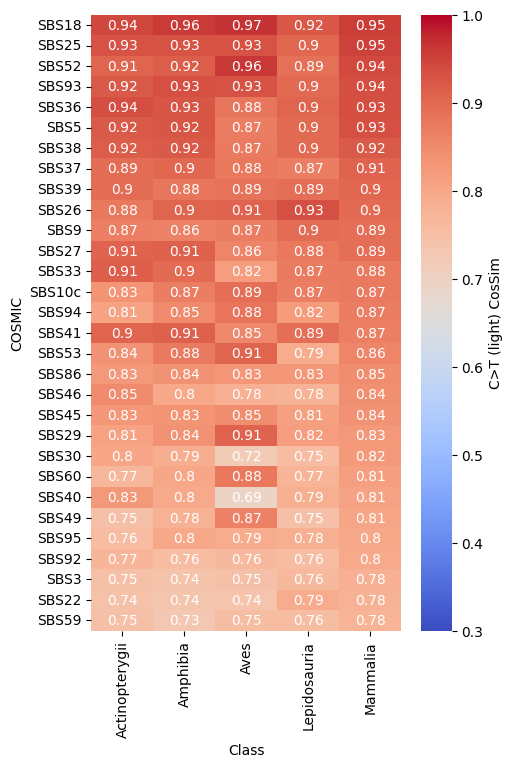

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(similarities_ct_light.head(30), annot=True, vmax=1, vmin=0.3, cmap="coolwarm", cbar_kws={"label": "C>T (light) CosSim"}, annot_kws={"color":"w"})
plt.show()

In [ ]:
similarities_ct_light["Effect"] = similarities_ct_light.index.map(sbs2effect)

In [ ]:
print(similarities_ct_light.round(2).head(20))

Class   Actinopterygii  Amphibia  Aves  Lepidosauria  Mammalia          Effect
COSMIC                                                                        
SBS18             0.94      0.96  0.97          0.92      0.95             ROS
SBS25             0.93      0.93  0.93          0.90      0.95       Treatment
SBS52             0.91      0.92  0.96          0.89      0.94        Artifact
SBS93             0.92      0.93  0.93          0.90      0.94             NaN
SBS36             0.94      0.93  0.88          0.90      0.93  BER_deficiency
SBS5              0.92      0.92  0.87          0.90      0.93             NaN
SBS38             0.92      0.92  0.87          0.90      0.92              UV
SBS37             0.89      0.90  0.88          0.87      0.91             NaN
SBS39             0.90      0.88  0.89          0.89      0.90             NaN
SBS26             0.88      0.90  0.91          0.93      0.90  MMR_deficiency
SBS9              0.87      0.86  0.87          0.90

## H - L
we want to get cosine similarity for all single-strand specific mutations (asymmetric ones), which we can get as heavy chain mutations minus light
strand mutations (we subtract reverse complement equivalent motivs, for example CCC>CTC on heavy strand - GGG>GAG on light strand). Finally we will get 96 numbers (minus some NA) which is good to have in terms of COSMIC (6 base substitution).
<!-- ```
Gh>Th - Gl>Tl (Ch>Ah)
Ch>Gh - Cl>Gl (Gh>Ch)
Ch>Th - Cl>Tl (Gh>Ah)
Ah>Th - Al>Tl (Th>Ah)
Ah>Gh - Al>Gl (Th>Ch)
Th>Gh - Tl>Gl (Ah>Ch)
``` -->

In [ ]:
# sbs6_main = ["G>T", "C>G", "C>T", "A>T", "A>G", "T>G"]
sbs6_main = cosmic.index.str.slice(2,5).unique().values
sbs6_main

array(['C>A', 'C>G', 'C>T', 'T>A', 'T>C', 'T>G'], dtype=object)

In [ ]:
cls_spectra_heavy = cls_spectra[cls_spectra.sbs12h.isin(sbs6_main)].rename(columns={"sbs192h": "sbs96", "sbs12h": "sbs6"}).drop(["sbs192l", "sbs12l"], axis=1)
cls_spectra_light = cls_spectra[cls_spectra.sbs12l.isin(sbs6_main)].rename(columns={"sbs192l": "sbs96", "sbs12l": "sbs6"}).drop(["sbs192h", "sbs12h"], axis=1)

In [ ]:
cls_spectra96 = cls_spectra_heavy.merge(cls_spectra_light.drop("sbs6", axis=1), on=["Class", "sbs96"], suffixes=["_h", "_l"])
cls_spectra96["Diff"] = cls_spectra96.MutSpec_h - cls_spectra96.MutSpec_l
cls_spectra96.head()

,Class,sbs96,MutSpec_h,sbs6,MutSpec_l,Diff
0,Actinopterygii,A[C>A]A,0.000786,C>A,0.0,0.000786
1,Actinopterygii,A[C>A]C,0.001114,C>A,0.0,0.001114
2,Actinopterygii,A[C>A]G,0.001247,C>A,0.0,0.001247
3,Actinopterygii,A[C>A]T,0.000000,C>A,0.0,0.000000
4,Actinopterygii,A[C>G]A,0.003199,C>G,0.0,0.003199


Some values are **negative** bacause values on light strand for some substitutions ware greater

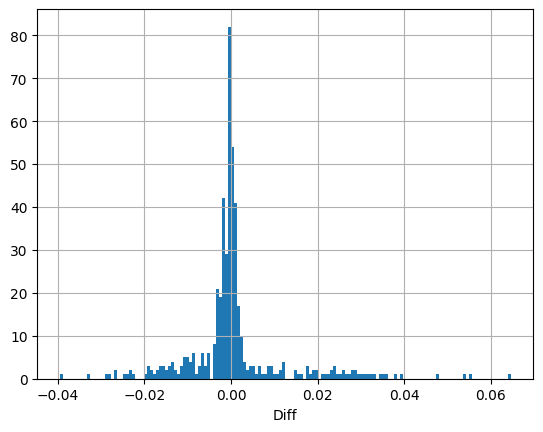

In [ ]:
cls_spectra96.Diff.hist(bins=150)
plt.xlabel("Diff");

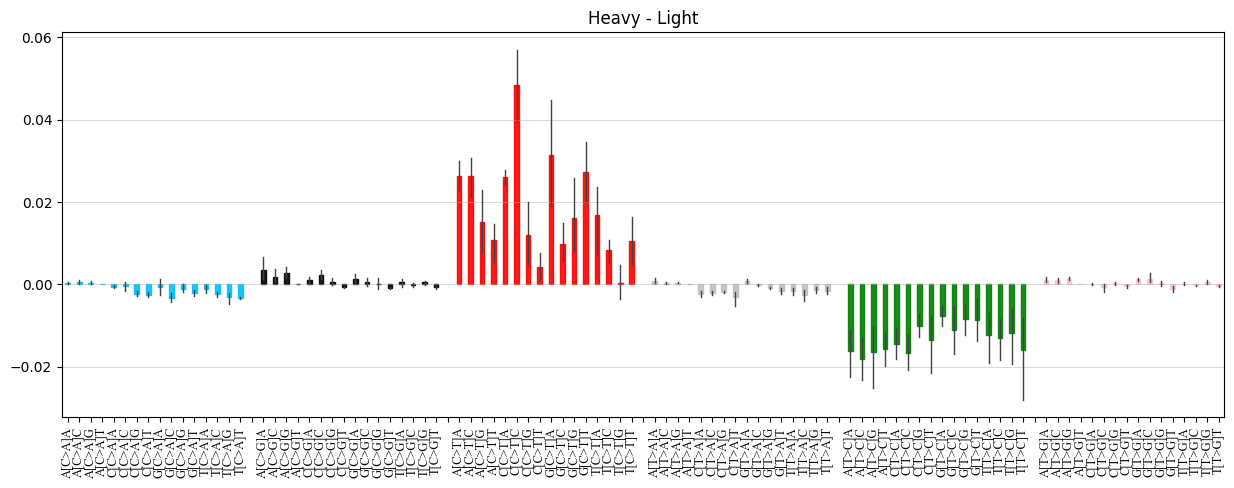

In [ ]:
plot_mutspec96(cls_spectra96.rename(columns={"sbs96": "Mut"}), "Diff", "Heavy - Light")

In [ ]:
data2 = []
for cls_name, gr in cls_spectra96.groupby("Class"):
    cosm_subset = cosmic96.loc[gr.sbs96]
    for col in cosm_subset.columns:
        cos_dist = spatial.distance.cosine(cosm_subset[col], gr.MutSpec)
        data2.append({
            "Class": cls_name,
            "COSMIC": col,
            "CosSim": 1 - cos_dist,
        })

similarities_diff_light = pd.DataFrame(data2).pivot("Class", "COSMIC", "CosSim").T\
    .sort_values(['Mammalia', 'Aves','Actinopterygii', 'Amphibia', 'Lepidosauria'], ascending=False)

In [ ]:
gr

,Class,sbs96,MutSpec_h,sbs6,MutSpec_l,Diff
0,Actinopterygii,A[A>G]A,0.010700,A>G,0.004133,0.006568
1,Actinopterygii,A[A>G]C,0.014734,A>G,0.007639,0.007096
2,Actinopterygii,A[A>G]G,0.011472,A>G,0.003063,0.008408
3,Actinopterygii,A[A>G]T,0.014797,A>G,0.006446,0.008351
4,Actinopterygii,A[A>T]A,0.001568,A>T,0.000000,0.001568
...,...,...,...,...,...,...
91,Actinopterygii,T[G>T]T,0.000000,G>T,0.000786,-0.000786
92,Actinopterygii,T[T>G]A,0.000537,T>G,0.000527,0.000010
93,Actinopterygii,T[T>G]C,0.000333,T>G,0.000569,-0.000236
94,Actinopterygii,T[T>G]G,0.001069,T>G,0.000747,0.000321


In [ ]:
similarities_diff_light.head(10)

In [ ]:
plt.figure(figsize=(5, 8))
sns.heatmap(similarities_diff_light.head(30), annot=True, vmax=1, vmin=0.3, cmap="coolwarm", cbar_kws={"label": "C>T (light) CosSim"}, annot_kws={"color":"w"})
plt.show()

# Legacy (DI)

In [62]:
import numpy as np
import pandas as pd
from scipy import spatial

### Download mutspec of vertebrates and SBS cosmic data 

In [50]:
mut_vert = pd.read_csv('../data/MutSpecVertebratescytb.csv')
cosm_sbs = pd.read_table('../data/external/COSMIC_v3.3.1_SBS_GRCh37.txt')

### Change format of cosmic data

In [51]:
cosm_sbs = cosm_sbs.rename(index=cosm_sbs.Type).drop(['Type'], axis=1)
cosm_sbs = cosm_sbs.transpose().reset_index()

In [52]:
cosm_sbs = cosm_sbs.melt("index", cosm_sbs.columns[1:], var_name="Mut")
cosm_sbs['MutBase'] = cosm_sbs.Mut.str.slice(2,5)
cosm_sbs = cosm_sbs.rename(columns={'index':'sbs_type', 'value':'MutSpec'})
cosm_sbs['AncestorCodon'] = cosm_sbs.Mut.str.get(0) + cosm_sbs.Mut.str.get(2) + cosm_sbs.Mut.str.get(-1)
cosm_sbs.head()

,sbs_type,Mut,MutSpec,MutBase,AncestorCodon
0,SBS1,A[C>A]A,8.861572e-04,C>A,ACA
1,SBS2,A[C>A]A,5.800168e-07,C>A,ACA
2,SBS3,A[C>A]A,2.080832e-02,C>A,ACA
3,SBS4,A[C>A]A,4.219650e-02,C>A,ACA
4,SBS5,A[C>A]A,1.199760e-02,C>A,ACA


In [53]:
cosm_comp = cosm_sbs[cosm_sbs.MutBase == 'C>T']
cosm_comp.head()

,sbs_type,Mut,MutSpec,MutBase,AncestorCodon
632,SBS1,A[C>T]A,0.025004,C>T,ACA
633,SBS2,A[C>T]A,0.000061,C>T,ACA
634,SBS3,A[C>T]A,0.014206,C>T,ACA
635,SBS4,A[C>T]A,0.008699,C>T,ACA
636,SBS5,A[C>T]A,0.032593,C>T,ACA


### Count MutSpec for all vertebrates

In [54]:
mut_vert.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [55]:
mut_vert = mut_vert.groupby(['Mut'])['RawMutSpec'].sum().reset_index()
mut_vert["RawMutSpecSum"] = mut_vert.RawMutSpec.sum()
mut_vert['MutSpec'] = mut_vert.RawMutSpec / mut_vert.RawMutSpecSum
mut_vert = mut_vert.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)


### Save 192 comp MutSpec for ALL vertebrates 

In [151]:
mut_vert.to_csv('../data/MutSpecALLvert.csv', index=False)

In [59]:
mut_vert['MutBase'] = mut_vert.Mut.str.slice(2,5)
mut_vert['AncestorCodon'] = mut_vert.Mut.str.get(0) + mut_vert.Mut.str.get(2) + mut_vert.Mut.str.get(-1)
mut_to_comp = mut_vert[mut_vert.MutBase == 'G>A']


### Count similarity betweeen each SBSX and MutSpec of vertebrates (G>A)

In [141]:
cos_res = []
for sbs in cosm_comp.sbs_type.drop_duplicates():
    sbs_to_cosine = cosm_comp[cosm_comp.sbs_type == sbs]
    cos = spatial.distance.cosine(sbs_to_cosine['MutSpec'], mut_to_comp['MutSpec'])
    comp_r = {'SBS': sbs, 'Similarity': 1-cos}
    cos_res.append(comp_r)
cos_res = pd.DataFrame(cos_res)

In [142]:
cos_res.sort_values(by='Similarity').tail()

,SBS,Similarity
24,SBS18,0.914264
11,SBS9,0.927928
4,SBS5,0.952137
44,SBS38,0.954477
42,SBS36,0.961308


### Count simialrity between eqch SBSX and full MutSpec

In [87]:
def gettranslate(mut, reverse=True):
    translator = str.maketrans("ACGT", "TGCA")
    if reverse is True:
        mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = mut.translate(translator)
    return new_mut


def transform192_to96(asymmetry_df, df_transform):
    to_96_comp = []
    for num_subs in range(0,96):
        # define ancestral and mutbase from mutspec according on 96 comp from asymmetry
        anc = asymmetry_df.iloc[num_subs, 4]
        mb = asymmetry_df.iloc[num_subs, 3]
        # get reverse subs with context
        rev_anc = gettranslate(anc, reverse=True)
        rev_mb = gettranslate(mb, reverse=False)
        # find mutspec num for the mutbase and context same with reverse, than devide on reverse
        rev_mutspec = df_transform[(df_transform.MutBase == rev_mb) & (df_transform.AncestorCodon == rev_anc)].MutSpec.values[0]
        mutspec = df_transform[(df_transform.MutBase == mb) & (df_transform.AncestorCodon == anc)].MutSpec.values[0]
        new_96_mut = mutspec/rev_mutspec
        #define row for future df
        out_mut = {'AncestorCodon': anc, 'MutBase': mb, 'MutSpec': new_96_mut}
        to_96_comp.append(out_mut)

    mut_96_comp = pd.DataFrame(to_96_comp)
    mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].replace(np.inf, 0)
    mut_96_comp["MutSpec"] = mut_96_comp["MutSpec"].fillna(0)
    return(mut_96_comp)

In [74]:
templ_as = cosm_sbs[cosm_sbs.sbs_type == 'SBS1']
templ_as.head()

,sbs_type,Mut,MutSpec,MutBase,AncestorCodon
0,SBS1,A[C>A]A,0.000886,C>A,ACA
79,SBS1,A[C>A]C,0.002280,C>A,ACC
158,SBS1,A[C>A]G,0.000177,C>A,ACG
237,SBS1,A[C>A]T,0.001280,C>A,ACT
316,SBS1,A[C>G]A,0.001860,C>G,ACA


In [90]:
mut_96_comp = transform192_to96(asymmetry_df=templ_as, df_transform=mut_vert)
mut_96_comp.head()

/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/ipykernel_86945/1364739460.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec
/var/folders/5l/9jtg_90x5s575m1zqn_h0kgm0000gn/T/ipykernel_86945/1364739460.py:21: RuntimeWarning: invalid value encountered in double_scalars
  new_96_mut = mutspec/rev_mutspec


,AncestorCodon,MutBase,MutSpec
0,ACA,C>A,0.0
1,ACC,C>A,0.0
2,ACG,C>A,0.0
3,ACT,C>A,0.0
4,ACA,C>G,0.0


In [91]:
cos_res = []
for sbs in cosm_sbs.sbs_type.drop_duplicates():
    sbs_to_cosine = cosm_sbs[cosm_sbs.sbs_type == sbs]
    cos = spatial.distance.cosine(sbs_to_cosine['MutSpec'], mut_96_comp['MutSpec'])
    comp_r = {'SBS': sbs, 'Similarity': 1-cos}
    cos_res.append(comp_r)
cos_res = pd.DataFrame(cos_res)

In [93]:
cos_res.sort_values(by='Similarity').tail()

,SBS,Similarity
4,SBS5,0.573457
38,SBS32,0.604126
16,SBS11,0.611283
29,SBS23,0.647296
36,SBS30,0.674522
